In [1]:
import numpy as np
import itertools as it
import sys
import json
import os
from scipy.special import softmax as softmax

import matplotlib.pyplot as plt


sys.path.append('../Comm/')
import utils as utils

import time

np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)
np.set_printoptions(linewidth=1000)


#inputs
coarse=0           #coarse = 1 ; non-coarse = 0
dth=5              #threshold for data [Available:5,12,15]
M=3                #memory states [Available:1,2,3,4]
A=4                #action size 4 -> [up,left,right,up]

max_obs = 10       # distinct observations for rewards
O = 2              # distinct observations for actions [0, 1, 2, .., O-1]

symmetry=1
replica=0          #if you wish to do multiple replicas

factor_dim = 1.0

Lx = int(92 * factor_dim)
Ly = int(131 * factor_dim)

#Dimension of grid: Lx by Ly.. For coarse set-up, Lx should be an odd number.
if coarse==1 and (Lx % 2) == 0:
    sys.exit('Error in value for Lx. In COARSE set-up, Lx should be an odd number')


#Location of source (Lx0,Ly0)
Lx0 = (Lx/2)-0.5
Ly0 = 91
# Ly0 = Ly * 0.70

#if coarse == 1:    #change size and center for coarse set-up
#    Lx=91
#    Lx0=45


##Default parameters
lr=0.01            #learning rate
find_range=1.1     #radius from source location to be considered as found target
# find_range=4.1     #radius from source location to be considered as found target
gamma=0.99975      #discount rate
V=100              #wind velocity for model plume


#combined action space = M * A, lM0, lM1, ... rM0, rM1, ..., uM0, uM1, ..., dM0, dM1, ...
a_size = A * M
L = Lx*Ly

# cost move!
cost_move = 1-gamma
reward_find=0.0
# reward_find=-0.0033

# probability of track
beta = 1
sigma = 4

#Maxtime in optimization
Ntot=1000000
Ntot=3
#Printing time interval
Nprint=100
Nprint=1

plotPrint=True

# ++++++++++++++++++
# CHANGE OF SCALES
scale = 1
L = int(L*scale)
sigma = sigma*scale
gamma = 1 - (1-gamma)/scale
beta = beta/scale
    
# Tolerance default
tol_eta = 0.00000001
tol_Q = 0.00000001
lr_th = 0.001
tol_conv = 0.0000000001    

## Questions 

What means the convergence of the algorithm?

Is important the amount of step that takes to reach the source?

How to interpret the policy map?

Why if I try to use the half of the space start to show an another source?

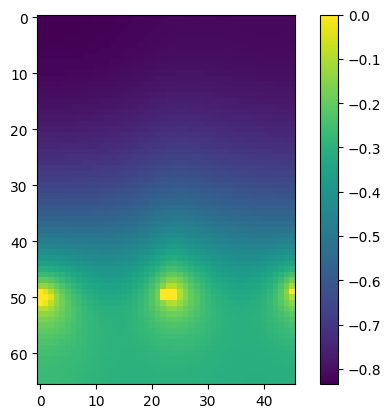

In [2]:
#To use an input file, change input_file=1. The default inputs are from the previous cell.
input_file=0

if input_file==1:    
    params = json.load(open('input.dat'))   ##change the file name
    coarse=params['coarse']   
    p_th=params['thresh']
    M = params["M"]         # size of memory m = {0,1}
    A = params["A"]         # action available in list: {left, right, up, down} 


    O = params["O"]         # distinct observations for actions [0, 1, 2, .., O-1]
    max_obs = params["max_obs"]  # distinct observations for rewards

    symmetry=params['symmetry']
    replica = params["replica"]


    Lx = params["Lx"]
    Ly = params["Ly"]
    Lx0 = (Lx/2)-0.5
    Ly0 = params["Ly0"]

    if coarse==1 and (Lx % 2) == 0:
        sys.exit('Error in value for Lx. In COARSE set-up, Lx should be an odd number')

    # Tolerance override
    if ("tol_eta" in params.keys()):
        tol_eta = params["tol_eta"]
    if ("tol_Q" in params.keys()):
        tol_Q = params["tol_Q"]
    if ("lr_th" in params.keys()):
        lr_th = params["lr_th"]
    if ("tol_conv" in params.keys()):
        tol_conv = params["tol_conv"]

    find_range = params["find_range"]
    gamma = params["gamma"]
    V = 100
    if ("V" in params.keys()):
        V = params["V"]

    # combined action space = M * A, lM0, lM1, ... rM0, rM1, ..., sM0, sM1, ...
    a_size = A * M
    L = Lx*Ly

    # cost move
    cost_move = 1-gamma
    if ("cost_move" in params.keys()):
        beta = params["cost_move"]
    reward_find = params["reward_find"]

    beta = 5
    if ("beta" in params.keys()):
        beta = params["beta"]

    #Maxtime in optimization
    Ntot = params["Ntot"]
    #Printing time interval
    Nprint = params["Nprint"]


    #data
    if symmetry == 0:
        data=np.loadtxt('data/exp_plume_threshold{}.dat'.format(dth))
    if symmetry == 1:
        data=np.loadtxt('data/exp_plume_symmetric_threshold{}.dat'.format(dth))
    if coarse == 1:
        data=np.loadtxt('data/exp_plume_symmetric_coarse_threshold{}.dat'.format(dth))

    #++++++++
    #INITIALIZATIONS


    eta = np.zeros(L*M)
    PObs_lim, RR, PObs,RR_np = utils.create_PObs_RR(Lx, Ly, Lx0, Ly0, find_range, cost_move, 
                                        reward_find, M, beta, max_obs, O, A, V, data=data,source_as_zero=source_as_zero)
    PObs_lim = np.abs(PObs_lim)

    # Initial density is only at y=0, proportional to signal probability
    rho0 = np.zeros(M*Lx*Ly)
    #rho0[:Lx*Ly0//2] = (1-PObs_lim[0,:Lx*Ly0//2])/np.sum((1-PObs_lim[0,:Lx*Ly0//2]))
    rho0[:Lx] = (1-PObs_lim[0,:Lx])/np.sum((1-PObs_lim[0,:Lx]))


    if ("ev" in params.keys()):
        rho0[:Lx*Ly0//2] = (1-PObs_lim[0,:Lx*Ly0//2])/np.sum((1-PObs_lim[0,:Lx*Ly0//2]))
    else:
        rho0[:Lx] = (1-PObs_lim[0,:Lx])/np.sum((1-PObs_lim[0,:Lx]))

    print('tol_conv:{}, tolQ:{}, toleta:{}'.format(tol_conv,tol_Q,tol_eta))   

In [3]:
#Create folder to save outputs
name_folder = 'outputs/ExpPlume_A{}M{}b{}g{}FR{}LR{}sym{}th{}rep{}LX{}LY{}co{}'.format(A,M,beta,gamma,find_range,lr_th,symmetry,dth,replica,Lx,Ly,coarse)
os.makedirs(name_folder, exist_ok=True)
#os.system("cp {} {}".format('./'+sys.argv[1], './'+name_folder))
f = open(name_folder+"/values.dat", "a")

In [4]:
print('Lx :{}, Ly :{}'.format(Lx, Ly))
print('Lx0:{}, Ly0:{}'.format(Lx0, Ly0))
print('M:{}, th:{}, replica:{}'.format(M, dth,replica))
print('tol_conv:{}, tolQ:{}, toleta:{}, learn_rate:{}'.format(tol_conv,tol_Q,tol_eta,lr_th))

#DATA UPLOAD - used to compute P(y|s)
if symmetry == 0:
    data=np.loadtxt('data/exp_plume_threshold{}.dat'.format(dth))
if symmetry == 1:
    data=np.loadtxt('data/exp_plume_symmetric_threshold{}.dat'.format(dth))
if coarse == 1:
    data=np.loadtxt('data/exp_plume_symmetric_coarse_threshold{}.dat'.format(dth))

#INITIALIZATIONS
yxs = it.product(np.arange(Ly), np.arange(Lx))
yx_founds = it.filterfalse(lambda x: (x[0]-Ly0)**2 + (x[1]-Lx0)**2 > find_range**2, yxs)
source_as_zero = np.array([i for i in yx_founds])

eta = np.zeros(L*M)
PObs_lim, RR, PObs, RR_np = utils.create_PObs_RR(Lx, Ly, Lx0, Ly0, find_range, cost_move, 
                                    reward_find, M, beta, max_obs, O, A, V, data=data,source_as_zero=source_as_zero)
PObs_lim = np.abs(PObs_lim)

# Initial density is only at y=0, proportional to signal probability
rho0 = np.zeros(M*Lx*Ly)
#rho0[:Lx*Ly0//2] = (1-PObs_lim[0,:Lx*Ly0//2])/np.sum((1-PObs_lim[0,:Lx*Ly0//2]))
rho0[:Lx] = (1-PObs_lim[0,:Lx])/np.sum((1-PObs_lim[0,:Lx]))

Lx :92, Ly :131
Lx0:45.5, Ly0:91
M:3, th:5, replica:0
tol_conv:1e-10, tolQ:1e-08, toleta:1e-08, learn_rate:0.001


rho0 shape:(36156,)


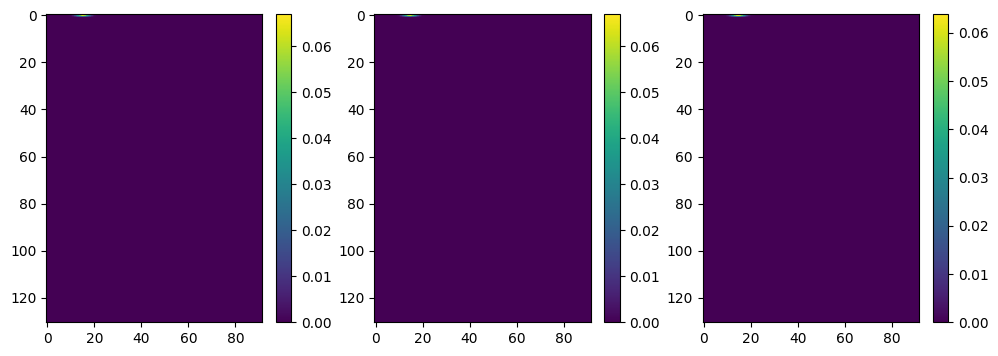

In [5]:
print("rho0 shape:{}".format(rho0.shape))
rho_map = rho0.reshape((Ly,Lx,M))
plt.figure(figsize=(12,12//M))
for m in range(M):
    plt.subplot(1,M,m+1)
    plt.imshow(rho_map[:,:,m])
    plt.colorbar()


PObs_lim shape:(2, 36156), 36156


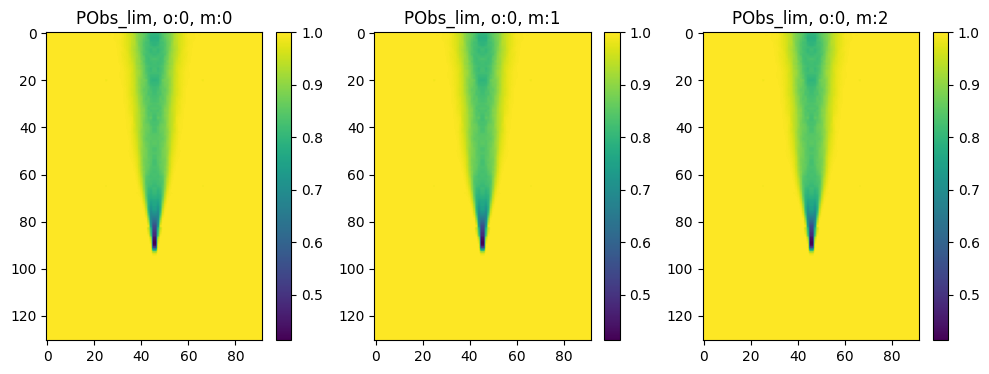

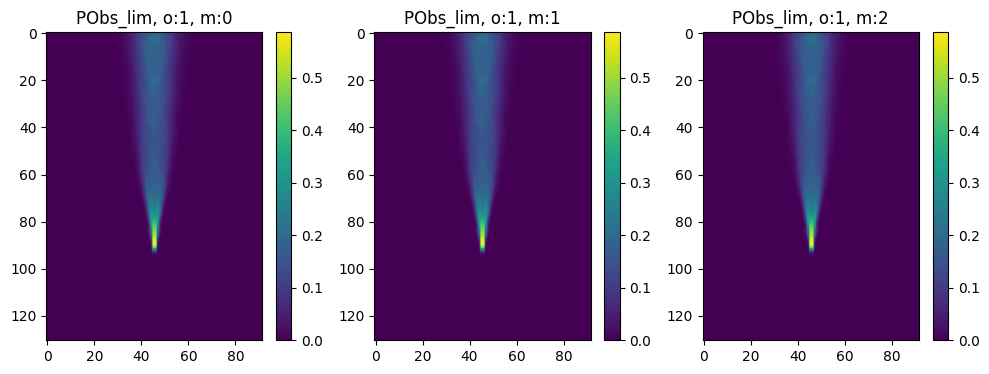

In [6]:
print("PObs_lim shape:{}, {}".format(PObs_lim.shape,Lx*Ly*M))
PObs_lim_map = PObs_lim.reshape((O,M,Ly,Lx))
for o in range(O):
    plt.figure(figsize=(12,12//M))
    for m in range(M):
        plt.subplot(1,M,m+1)
        plt.title('PObs_lim, o:{}, m:{}'.format(o,m))
        plt.imshow(PObs_lim_map[o,m,:,:])
        plt.colorbar()
    plt.show()

RR shape:  (433872,)
RR_np shape:  (3, 131, 92) 433872


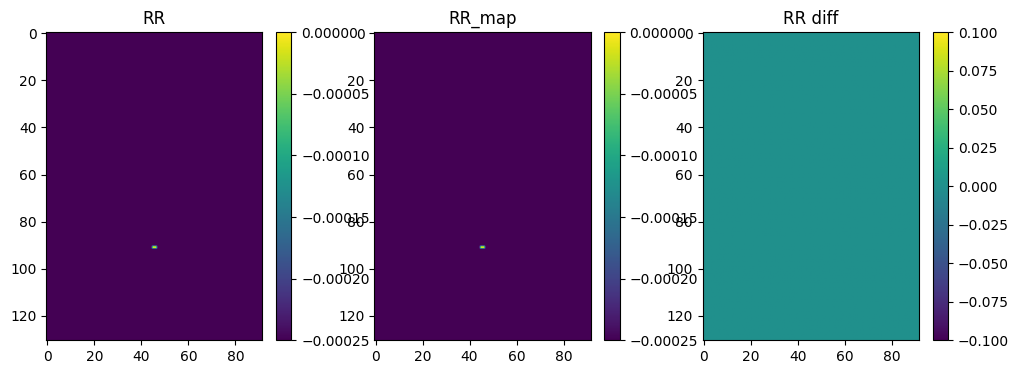

In [19]:
print("RR shape: ", RR.shape)
RR_map = RR.reshape((M,Ly,Lx,M,A))

print("RR_np shape: ", RR_np.shape, np.array(RR_np.shape).prod()*A*M)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title('RR')
plt.imshow(RR_np[0,:,:])
plt.colorbar()
plt.subplot(1,3,2)
plt.title('RR_map')
plt.imshow(RR_map[0,:,:,0,0])
plt.colorbar()
plt.subplot(1,3,3)
plt.title('RR diff')
plt.imshow(RR_map[0,:,:,0,0]-RR_np[0,:,:])
plt.colorbar()

plt.show()

In [8]:
# Policy Initialization with bias
restart = False
unbias = False    
if (restart):
    folder_restart = name_folder
    th = np.loadtxt(folder_restart + '/file_theta.out')
    th = th.reshape(O, M, a_size)
    Q = np.loadtxt(folder_restart + '/file_Q.out')
    eta = np.loadtxt(folder_restart + '/file_eta.out')
else:
    th = (np.random.rand(O, M, a_size)-0.5)*0.5 
    th[1:,:,2::A] += 0.5
    if (unbias):
        th[1:,:,2::A] -= 0.5
    eta = np.ones(eta.shape)/(L*M)/(1-gamma)
    Q = utils.create_random_Q0(Lx, Ly, Lx0, Ly0, gamma, a_size, M, cost_move, reward_find) 
       
pi = softmax(th, axis=2)

value = 0
oldvalue = value

value_lin = 0
oldvalue_lin = value_lin


In [9]:
print("pi shape: ", pi.shape)
print("th shape: ", th.shape)

pi shape:  (2, 3, 12)
th shape:  (2, 3, 12)


Q shape: (433872,) 
Q shape: (3, 131, 92, 3, 4) 


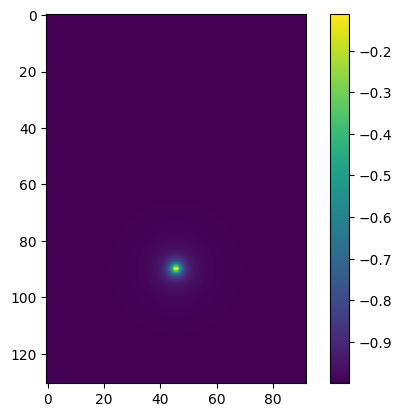

In [10]:
print("Q shape: {} ".format(Q.shape))
Q_map = Q.reshape(M,Ly,Lx,M,A)
print("Q shape: {} ".format(Q_map.shape))

plt.imshow(Q_map[1,:,:,0,3])
plt.colorbar()

Start optimization
   Direct solver eta time: 20.998 Q time: 11.508 Total time: 32.508
Iterative solver eta time: 19.799 Q time: 136.323 Total time: 156.122
eta linSol shape (36156,)
Q linSol shape (433872,)
eta shape (36156,)
Q shape (433872,)
Diff between Q fortran vs inverse
Memory state: 0, Action: 0, Diff: 337.6313770840341
    Inv min: -0.9749656725596164, max: 0.0
Fortran min: -0.9976991974071916, max: 0.0


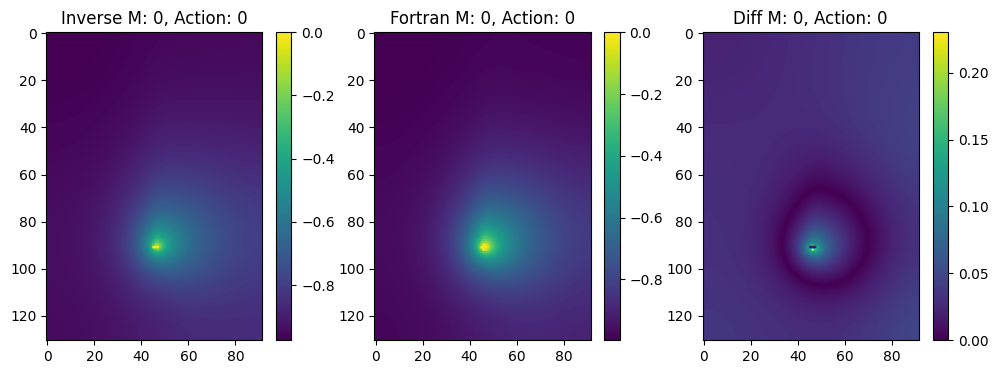

Memory state: 0, Action: 1, Diff: 340.84354476237786
    Inv min: -0.9749566540084765, max: 0.0
Fortran min: -0.9976943545375841, max: 0.0


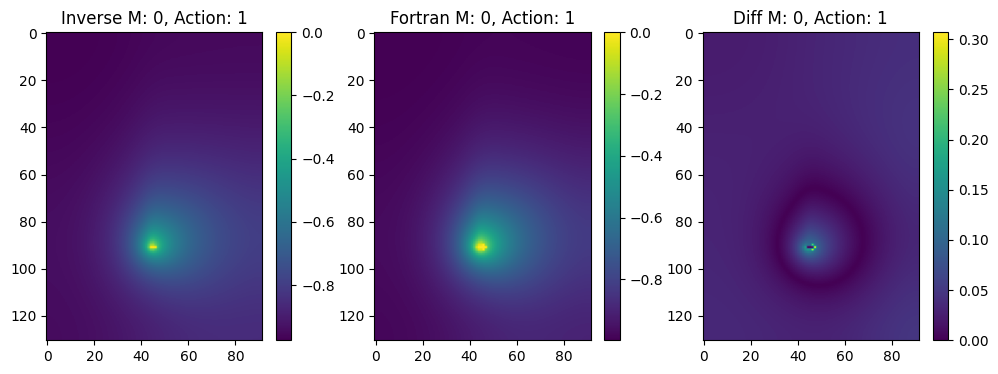

Memory state: 0, Action: 2, Diff: 339.5298106687012
    Inv min: -0.9749495039659971, max: 0.0
Fortran min: -0.9976905034149978, max: 0.0


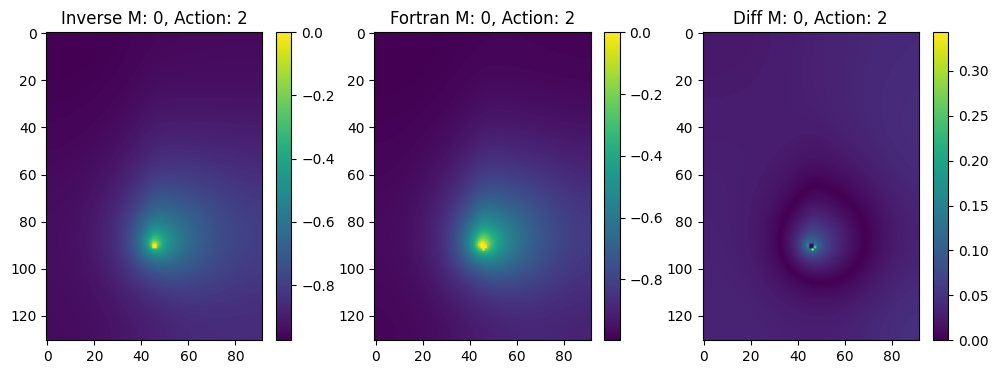

Memory state: 0, Action: 3, Diff: 338.7569587111231
    Inv min: -0.9749656725596164, max: 0.0
Fortran min: -0.9976991974071916, max: 0.0


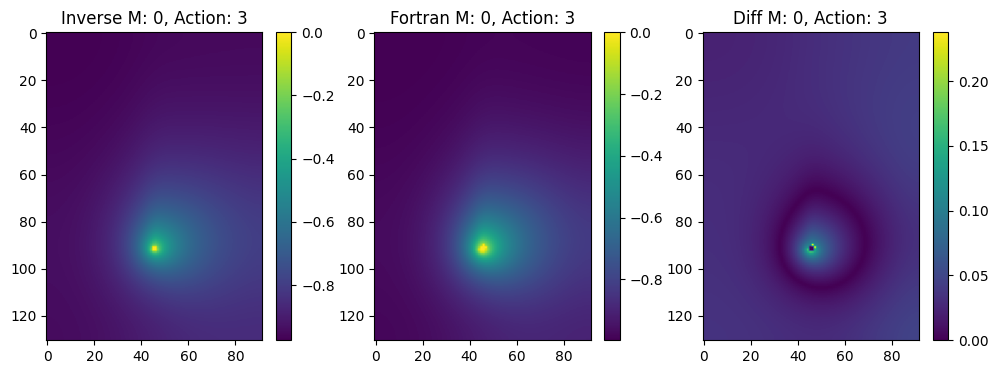

Memory state: 1, Action: 0, Diff: 337.61980947695315
    Inv min: -0.9749654969582534, max: 0.0
Fortran min: -0.9976991029234705, max: 0.0


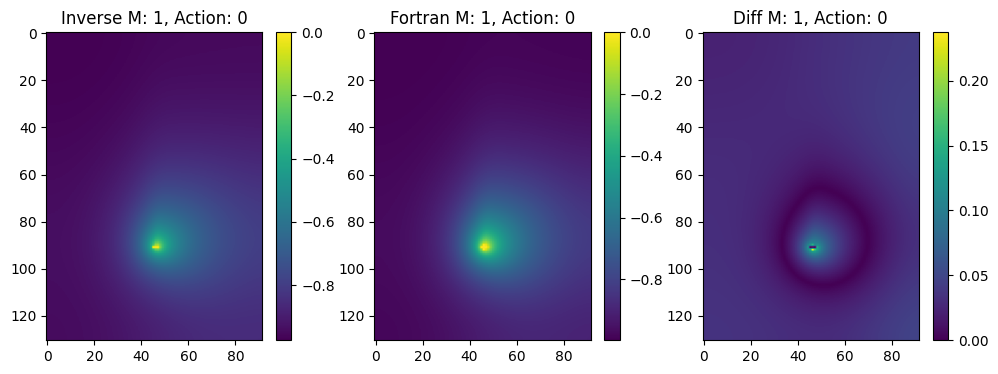

Memory state: 1, Action: 1, Diff: 340.82147684919033
    Inv min: -0.9749567071464232, max: 0.0
Fortran min: -0.9976943826624661, max: 0.0


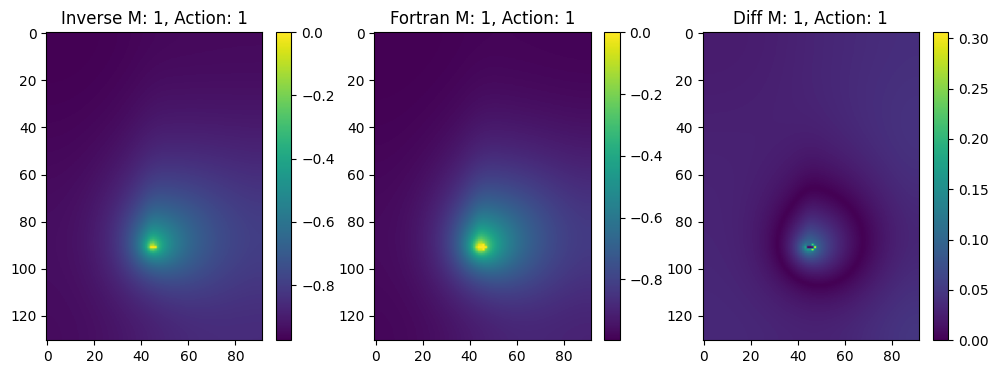

Memory state: 1, Action: 2, Diff: 339.56683258365035
    Inv min: -0.9749488910472404, max: 0.0
Fortran min: -0.9976901738394606, max: 0.0


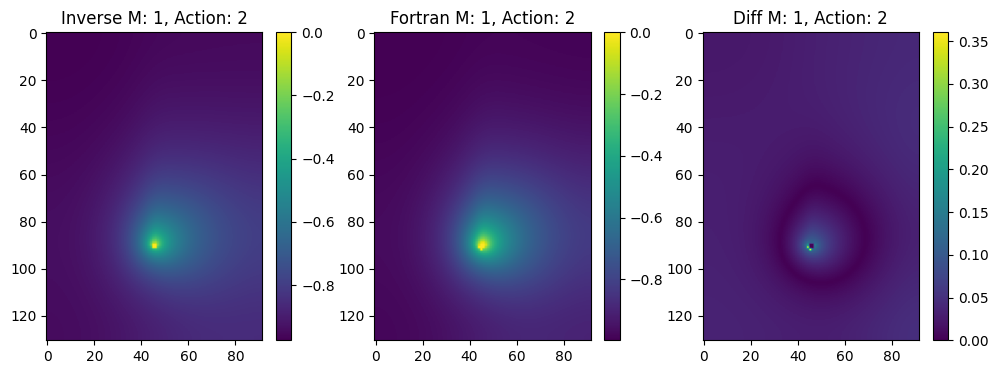

Memory state: 1, Action: 3, Diff: 338.80008782643006
    Inv min: -0.9749654969582534, max: 0.0
Fortran min: -0.9976991029234705, max: 0.0


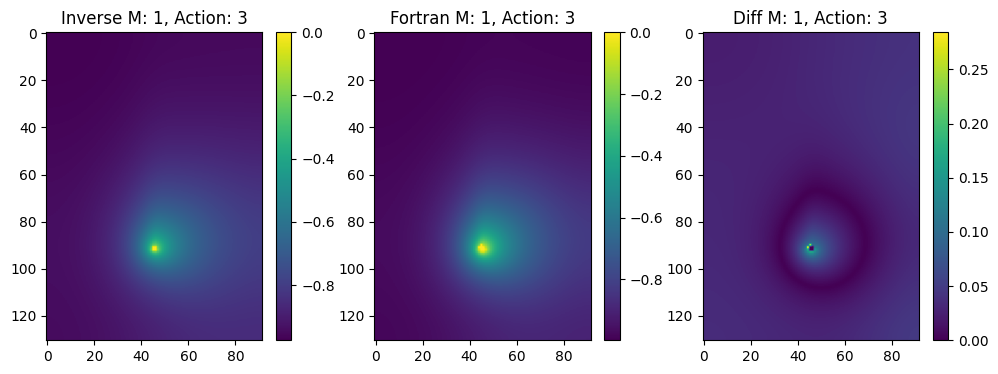

Memory state: 2, Action: 0, Diff: 338.1313392643712
    Inv min: -0.9749654566442686, max: 0.0
Fortran min: -0.9976990811952657, max: 0.0


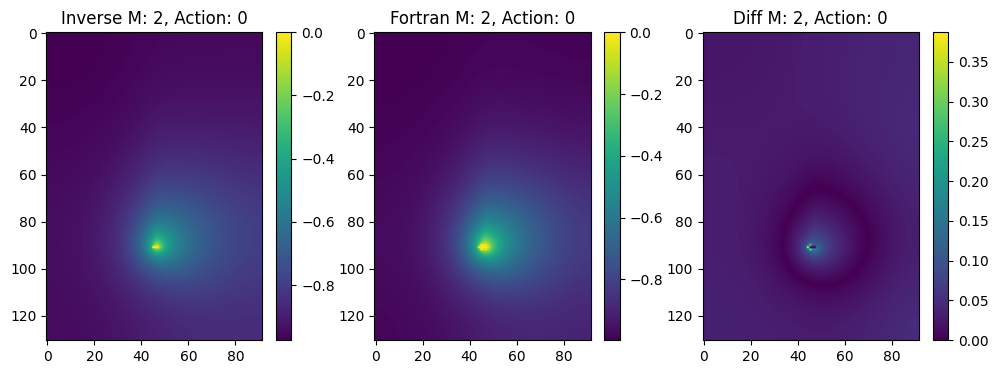

Memory state: 2, Action: 1, Diff: 340.4743362076199
    Inv min: -0.9749566225301638, max: 0.0
Fortran min: -0.9976943371174863, max: 0.0


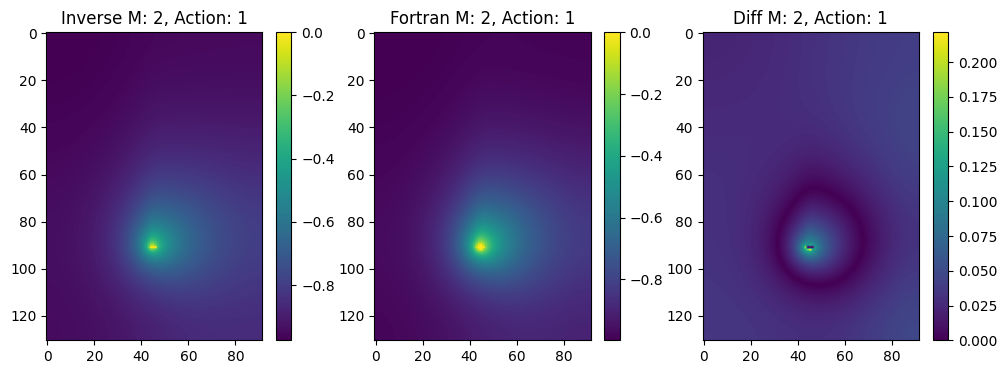

Memory state: 2, Action: 2, Diff: 339.5812350715222
    Inv min: -0.9749489964537041, max: 0.0
Fortran min: -0.9976902303997933, max: 0.0


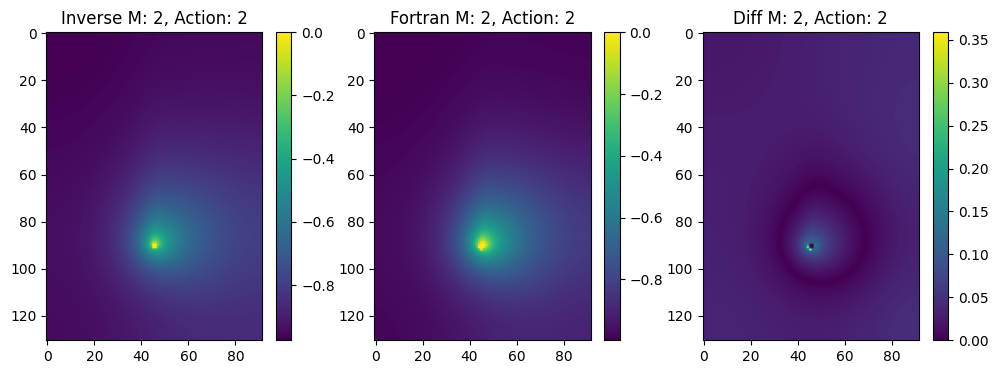

Memory state: 2, Action: 3, Diff: 338.81725743912693
    Inv min: -0.9749654566442686, max: 0.0
Fortran min: -0.9976990811952657, max: 0.0


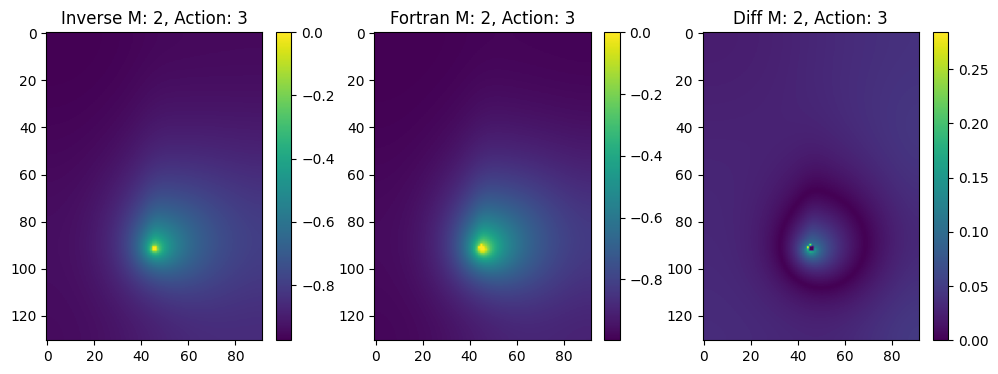

Diff between eta fortran vs inverse
0.0917988037162547


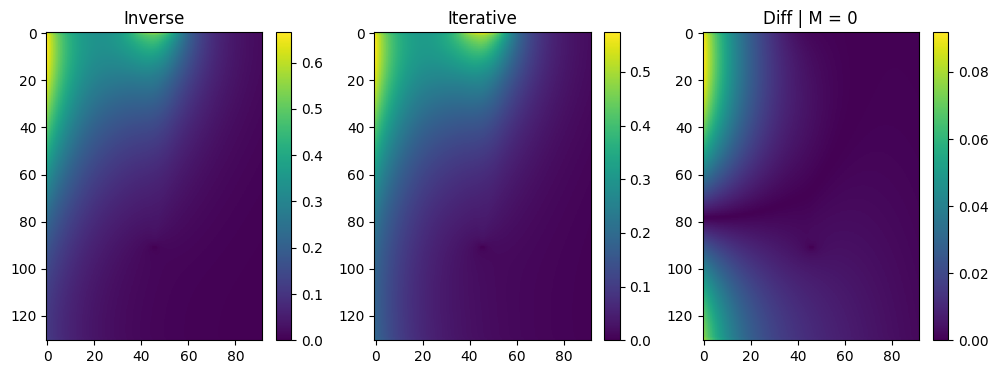

0.08895980385296265


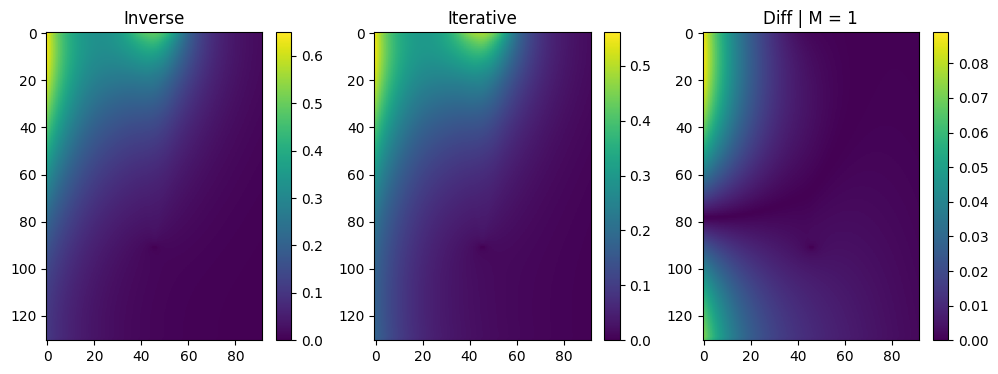

0.08637127889324359


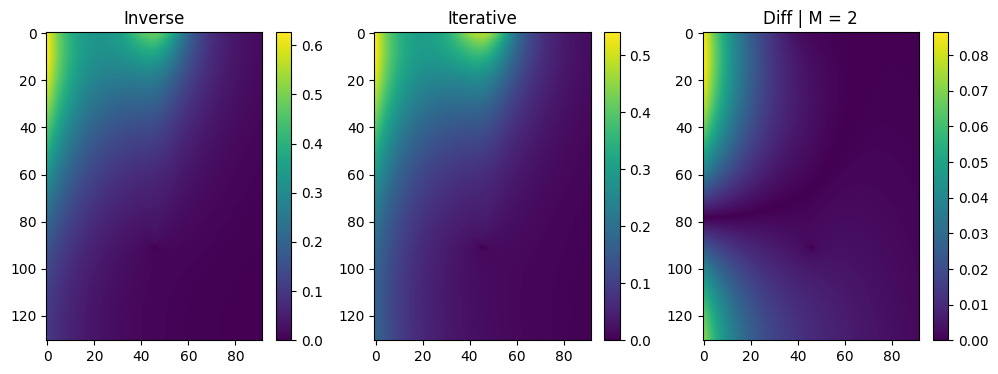

current value: -0.9876802602064714 @ time:0 

current value: -0.9573981489940353 @ time:0 

   Direct solver eta time: 6.355 Q time: 2.445 Total time: 8.801
Iterative solver eta time: 0.053 Q time: 0.080 Total time: 0.132
eta linSol shape (36156,)
Q linSol shape (433872,)
eta shape (36156,)
Q shape (433872,)
Diff between Q fortran vs inverse
Memory state: 0, Action: 0, Diff: 351.19878308266993
    Inv min: -0.9738636371549366, max: 0.0
Fortran min: -0.9976936149701137, max: 0.0


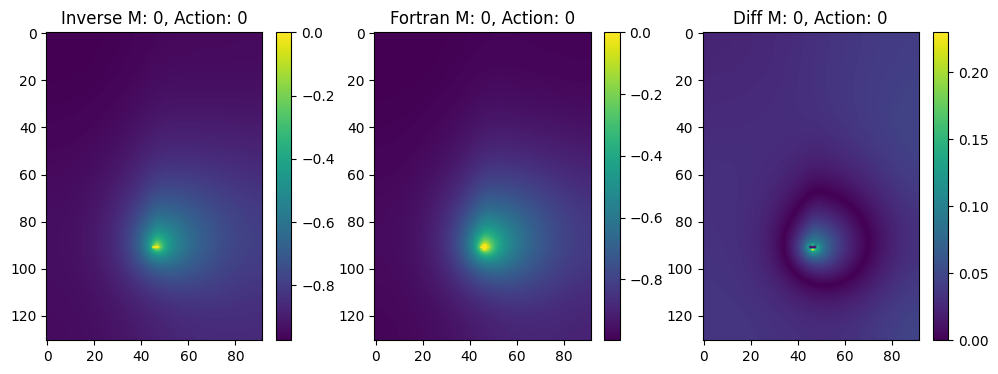

Memory state: 0, Action: 1, Diff: 354.2446196688226
    Inv min: -0.9738541824410759, max: 0.0
Fortran min: -0.9976887626638108, max: 0.0


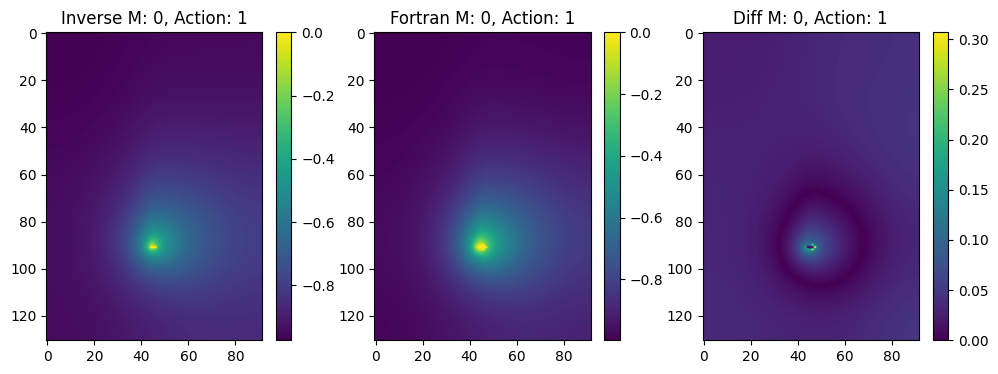

Memory state: 0, Action: 2, Diff: 352.9102898532558
    Inv min: -0.9738468058229761, max: 0.0
Fortran min: -0.9976849057336359, max: 0.0


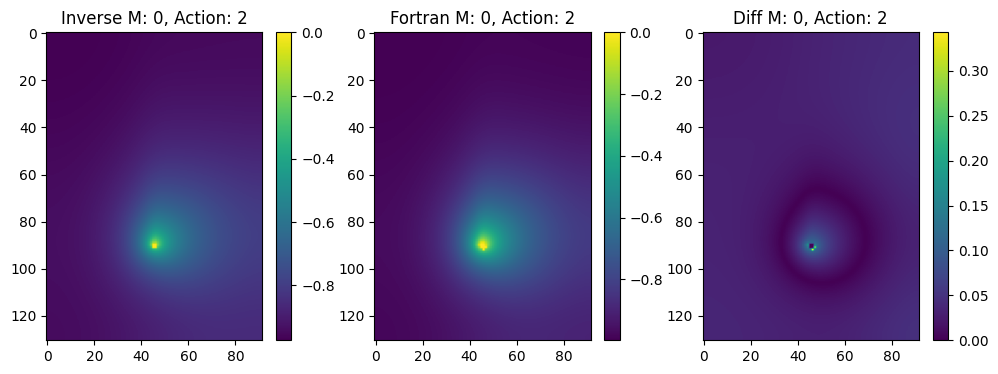

Memory state: 0, Action: 3, Diff: 352.3453375411635
    Inv min: -0.9738636371549366, max: 0.0
Fortran min: -0.9976936149701137, max: 0.0


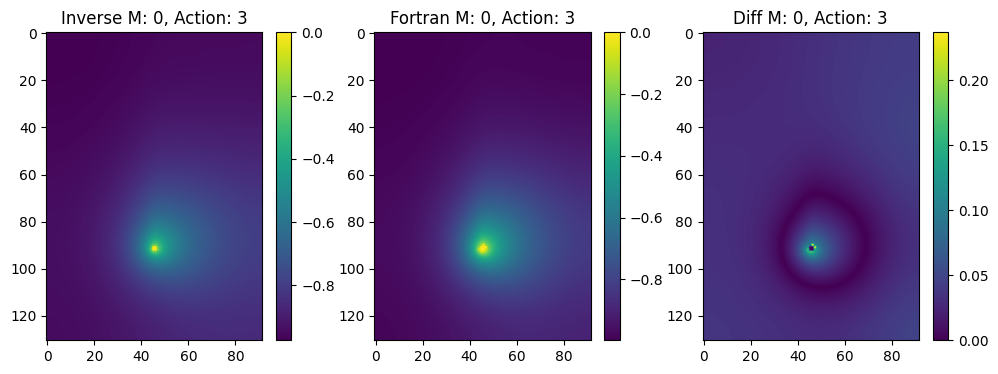

Memory state: 1, Action: 0, Diff: 351.1852921562876
    Inv min: -0.9738634557436594, max: 0.0
Fortran min: -0.9976935203696964, max: 0.0


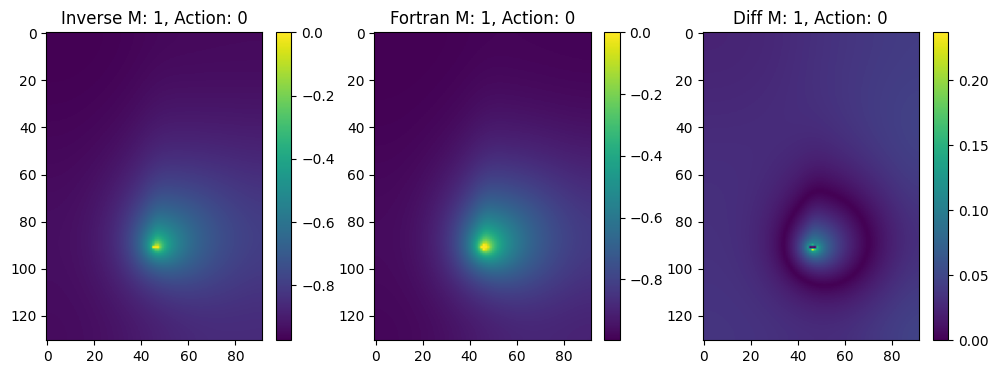

Memory state: 1, Action: 1, Diff: 354.2204949295582
    Inv min: -0.9738542408131714, max: 0.0
Fortran min: -0.9976887909498509, max: 0.0


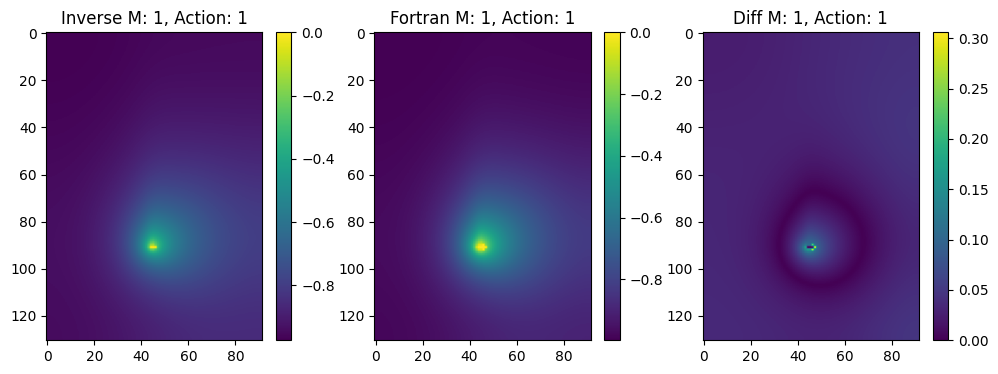

Memory state: 1, Action: 2, Diff: 352.9452938133741
    Inv min: -0.9738461695315669, max: 0.0
Fortran min: -0.9976845757144334, max: 0.0


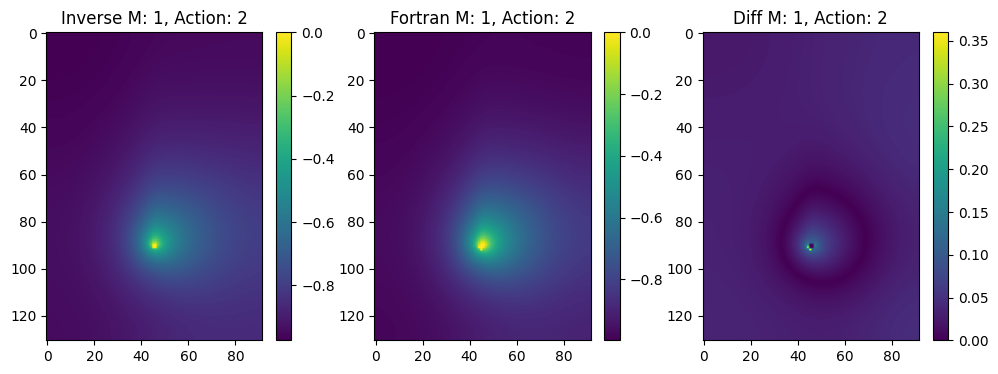

Memory state: 1, Action: 3, Diff: 352.386310388371
    Inv min: -0.9738634557436594, max: 0.0
Fortran min: -0.9976935203696964, max: 0.0


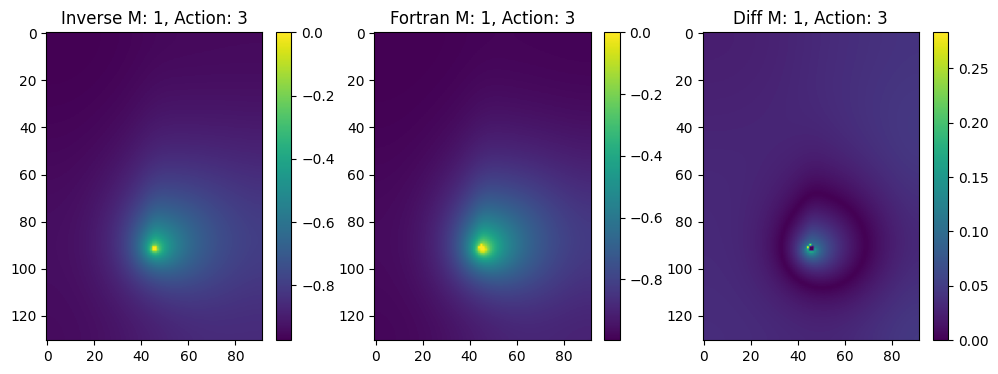

Memory state: 2, Action: 0, Diff: 351.6971891585504
    Inv min: -0.9738634144351107, max: 0.0
Fortran min: -0.9976934986234318, max: 0.0


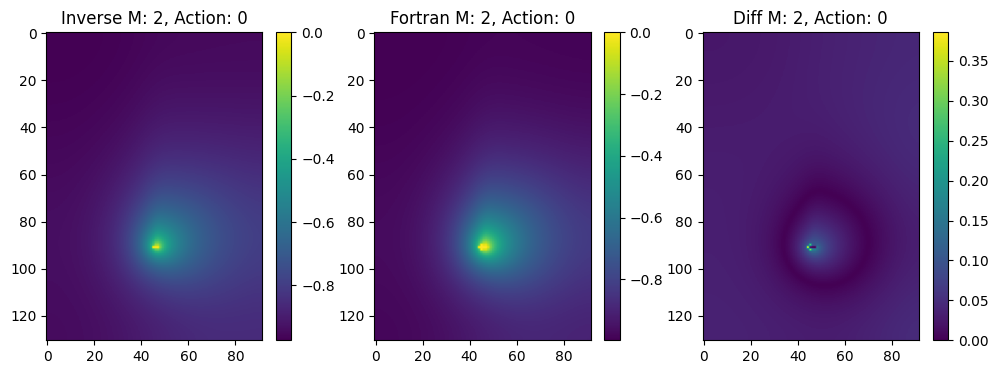

Memory state: 2, Action: 1, Diff: 353.8738062469482
    Inv min: -0.9738541530939092, max: 0.0
Fortran min: -0.997688745398023, max: 0.0


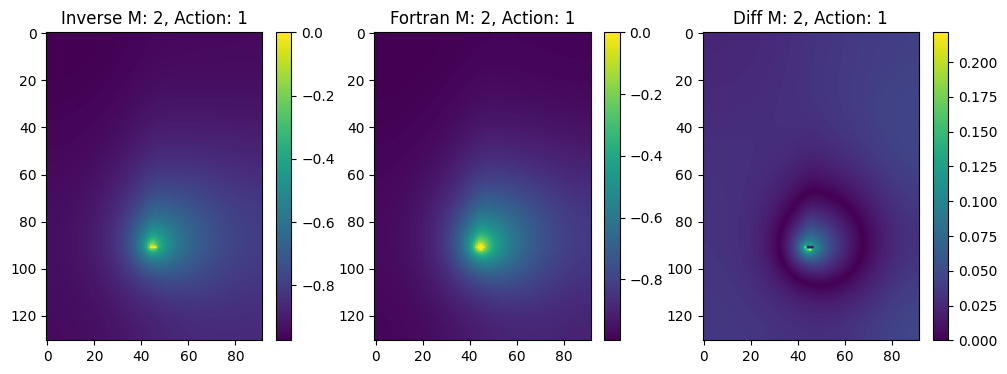

Memory state: 2, Action: 2, Diff: 352.96018748575125
    Inv min: -0.9738462798747847, max: 0.0
Fortran min: -0.9976846323220803, max: 0.0


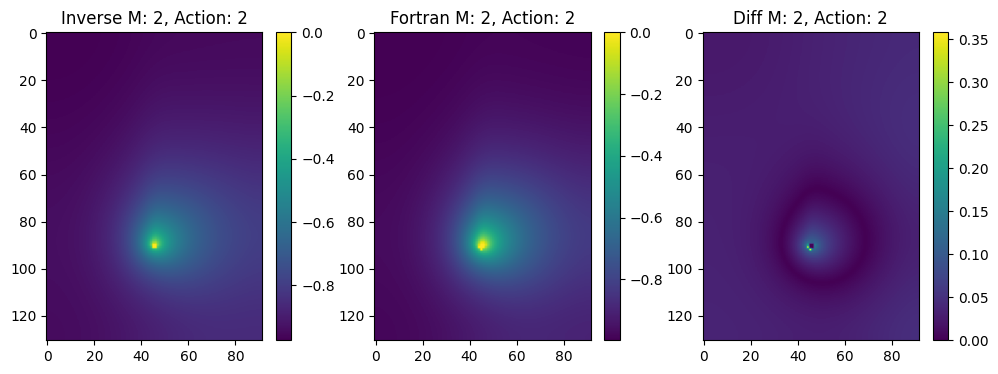

Memory state: 2, Action: 3, Diff: 352.40398795495787
    Inv min: -0.9738634144351107, max: 0.0
Fortran min: -0.9976934986234318, max: 0.0


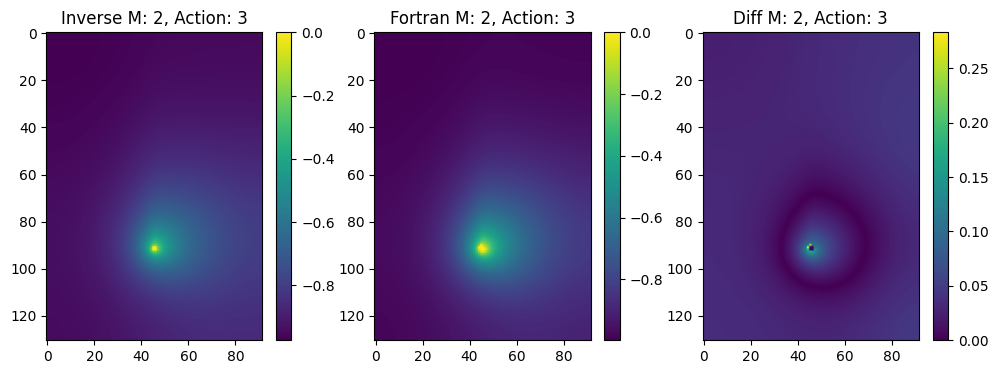

Diff between eta fortran vs inverse
0.07372287042236603


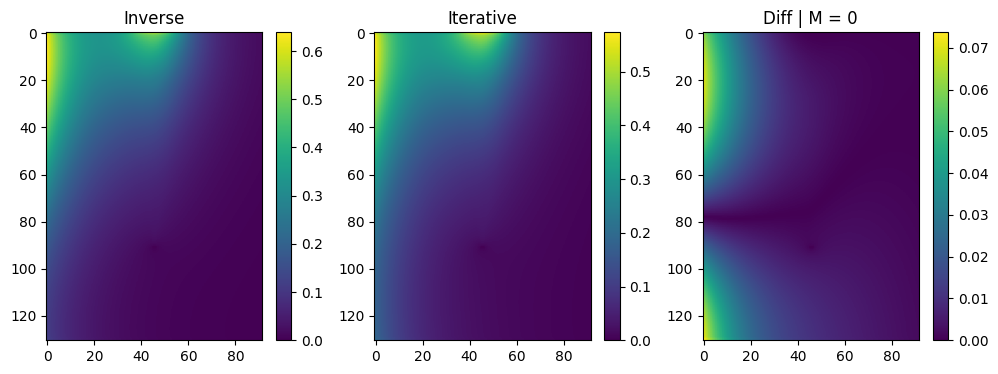

0.06738485756892493


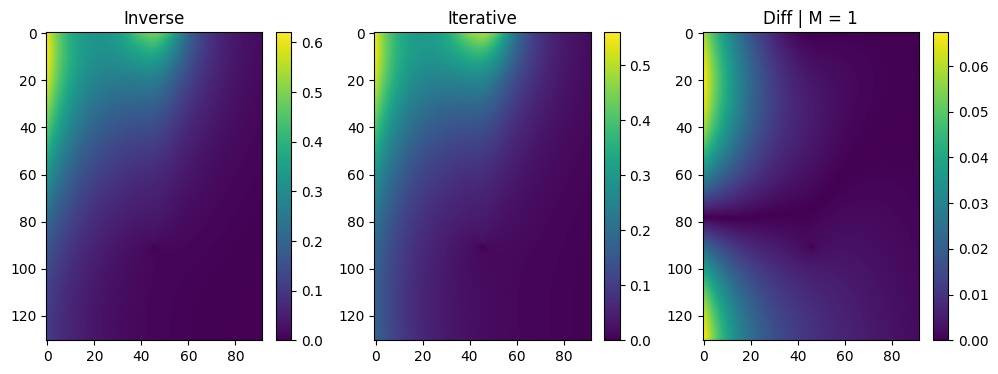

0.06646886385272294


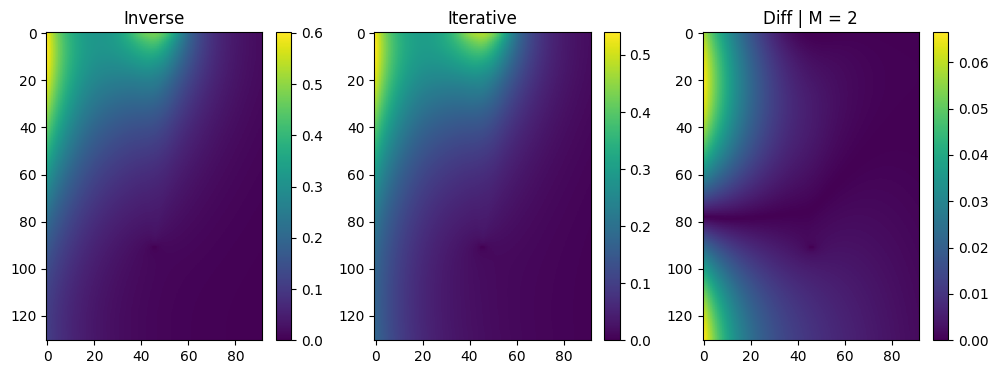

current value: -0.9876613698362052 @ time:1 

current value: -0.9557936093230358 @ time:1 

   Direct solver eta time: 6.283 Q time: 2.133 Total time: 8.416
Iterative solver eta time: 0.138 Q time: 0.433 Total time: 0.572
eta linSol shape (36156,)
Q linSol shape (433872,)
eta shape (36156,)
Q shape (433872,)
Diff between Q fortran vs inverse
Memory state: 0, Action: 0, Diff: 363.5665876454052
    Inv min: -0.9727368310965571, max: 0.0
Fortran min: -0.9976655380409439, max: 0.0


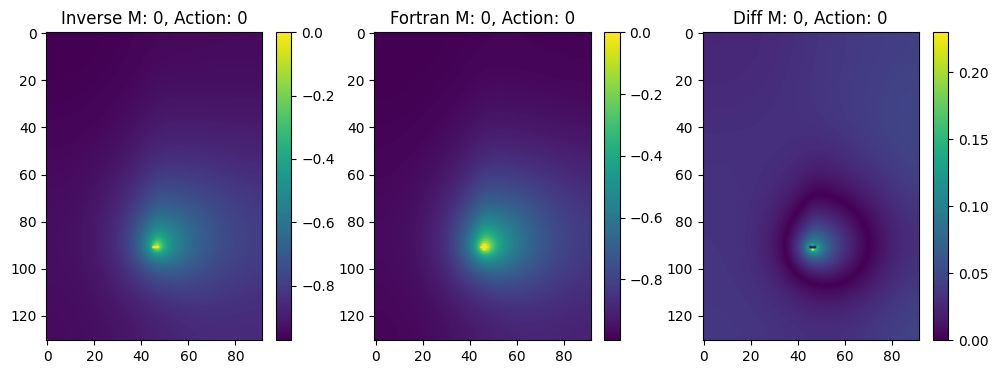

Memory state: 0, Action: 1, Diff: 366.3896020990479
    Inv min: -0.9727269277966629, max: 0.0
Fortran min: -0.9976606371797104, max: 0.0


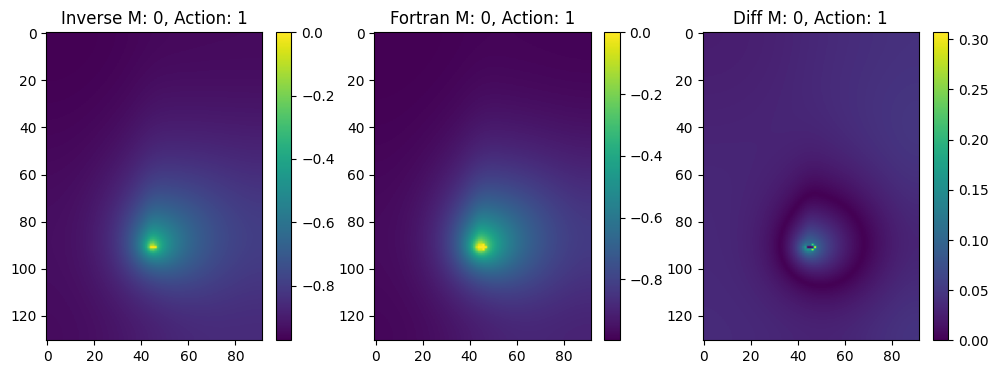

Memory state: 0, Action: 2, Diff: 365.0491541990258
    Inv min: -0.9727193253201791, max: 0.0
Fortran min: -0.9976567508143762, max: 0.0


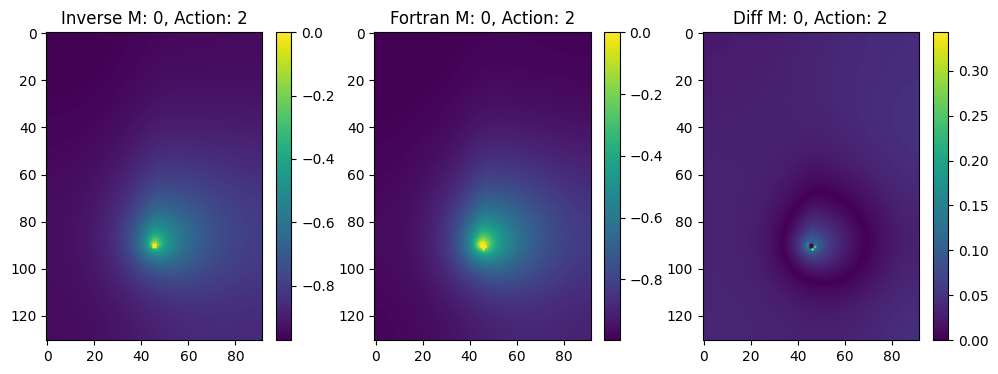

Memory state: 0, Action: 3, Diff: 364.71956926478526
    Inv min: -0.9727368310965571, max: 0.0
Fortran min: -0.9976655380409439, max: 0.0


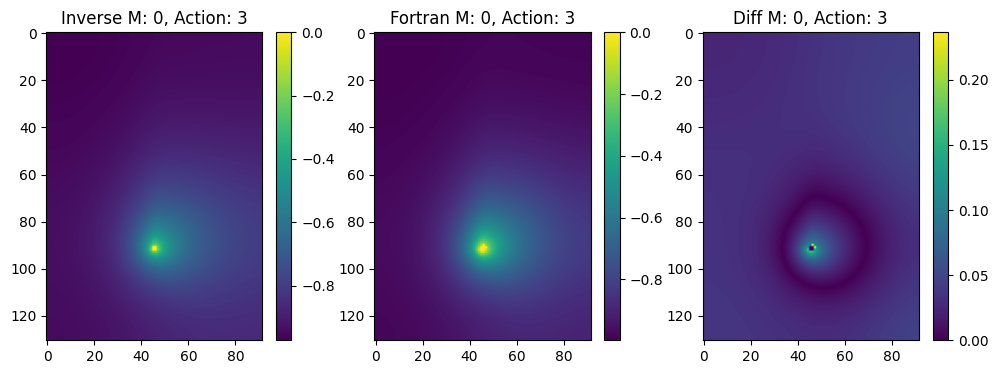

Memory state: 1, Action: 0, Diff: 363.5529336518557
    Inv min: -0.972736643872856, max: 0.0
Fortran min: -0.9976654427215687, max: 0.0


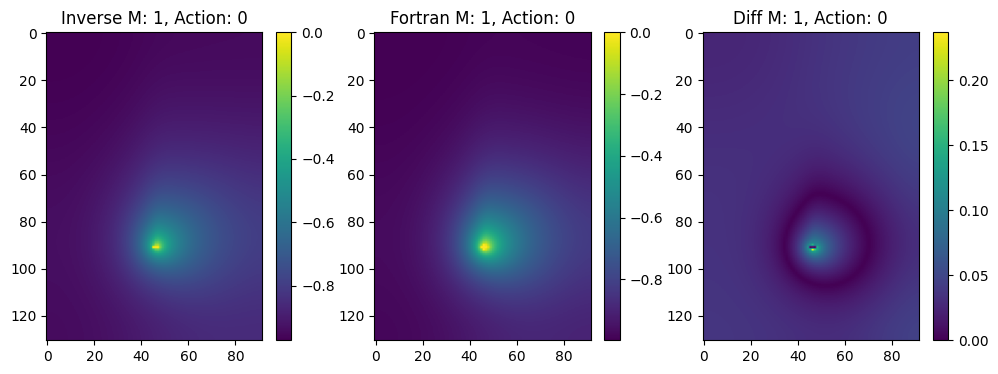

Memory state: 1, Action: 1, Diff: 366.3651701225048
    Inv min: -0.9727269917135151, max: 0.0
Fortran min: -0.9976606659622438, max: 0.0


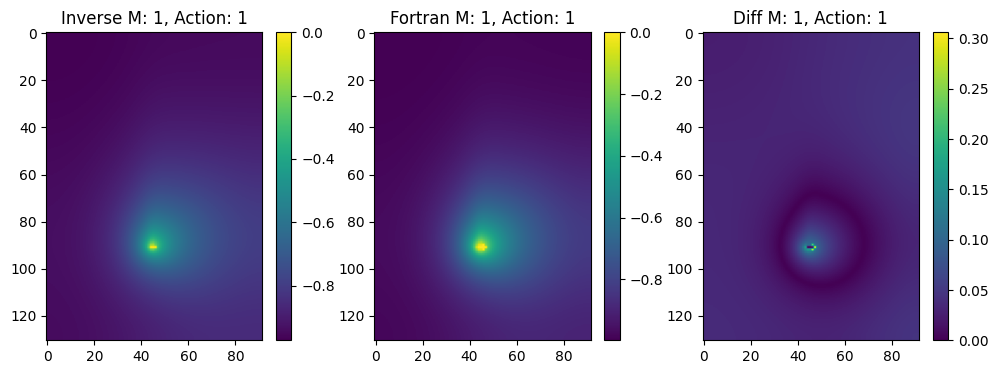

Memory state: 1, Action: 2, Diff: 365.0835653510683
    Inv min: -0.9727186653638775, max: 0.0
Fortran min: -0.9976564181441531, max: 0.0


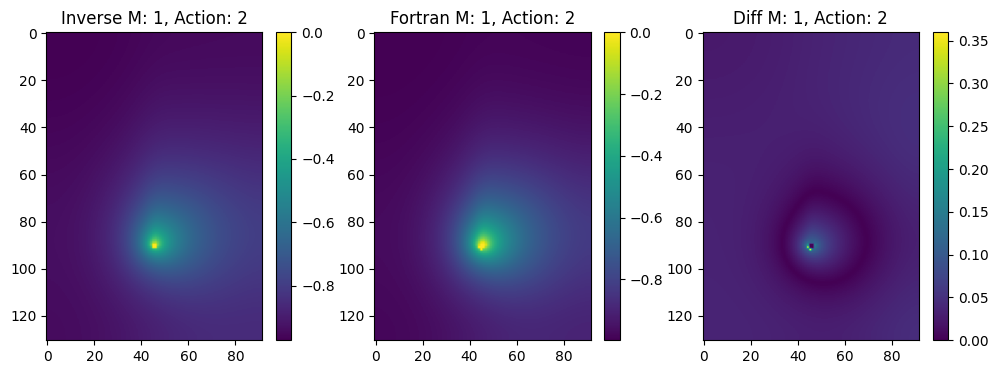

Memory state: 1, Action: 3, Diff: 364.759782240061
    Inv min: -0.972736643872856, max: 0.0
Fortran min: -0.9976654427215687, max: 0.0


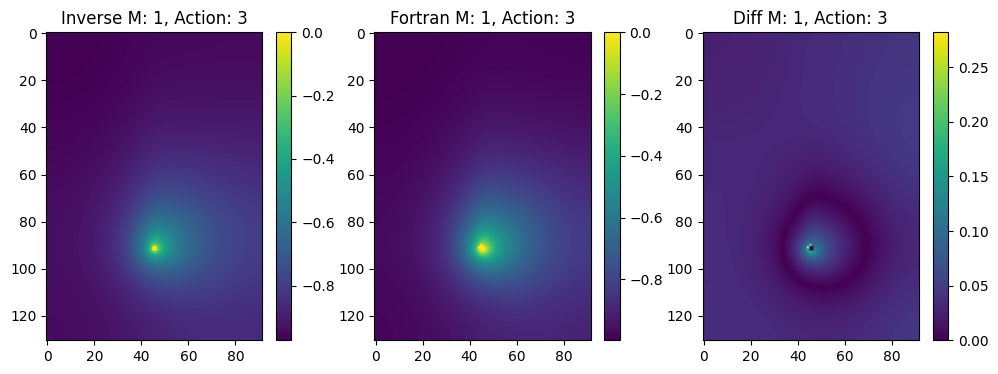

Memory state: 2, Action: 0, Diff: 364.06439455522354
    Inv min: -0.972736601599953, max: 0.0
Fortran min: -0.9976654208328039, max: 0.0


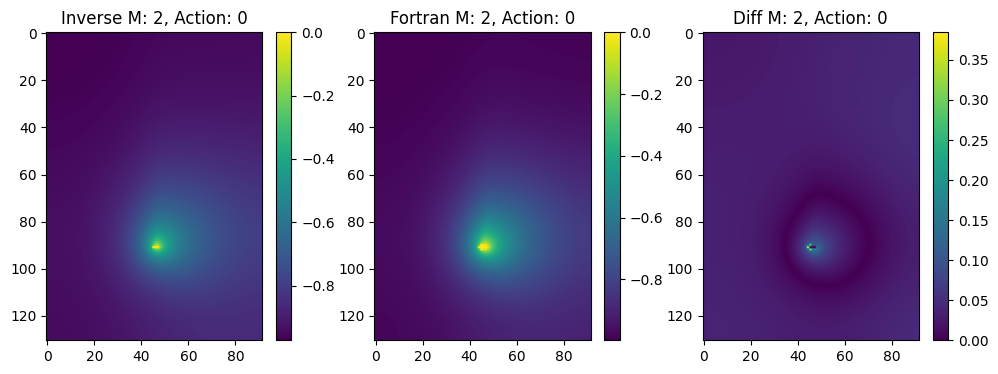

Memory state: 2, Action: 1, Diff: 366.01832364080497
    Inv min: -0.9727269008636171, max: 0.0
Fortran min: -0.9976606200460247, max: 0.0


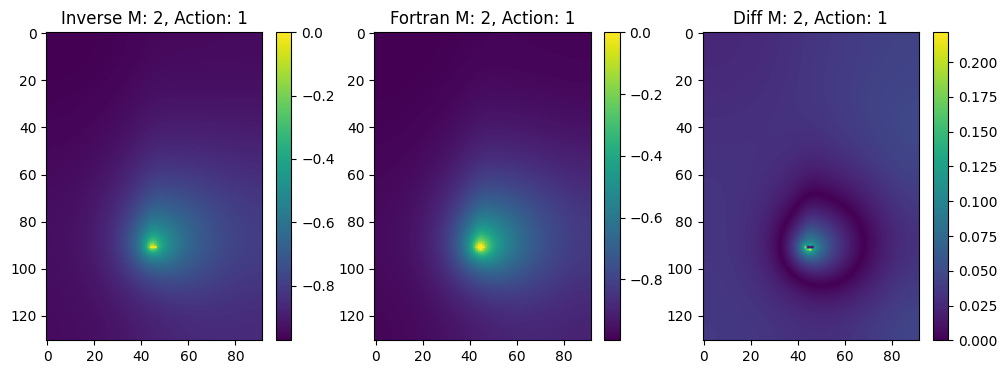

Memory state: 2, Action: 2, Diff: 365.09866821900204
    Inv min: -0.9727187807764728, max: 0.0
Fortran min: -0.9976564752994148, max: 0.0


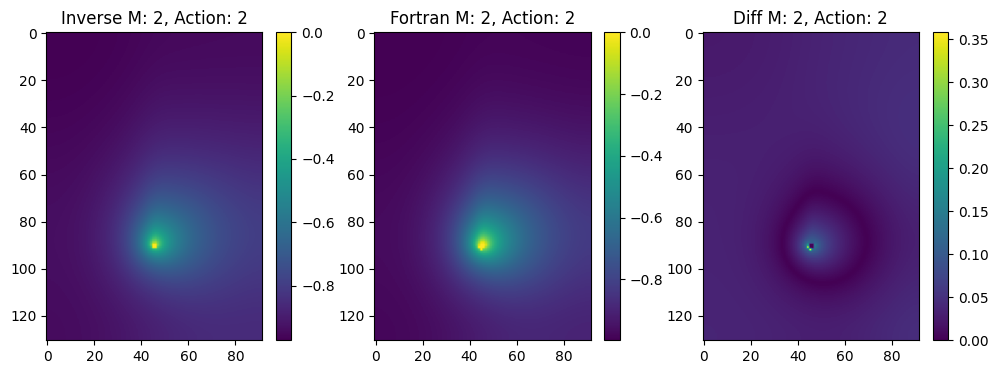

Memory state: 2, Action: 3, Diff: 364.77768909961617
    Inv min: -0.972736601599953, max: 0.0
Fortran min: -0.9976654208328039, max: 0.0


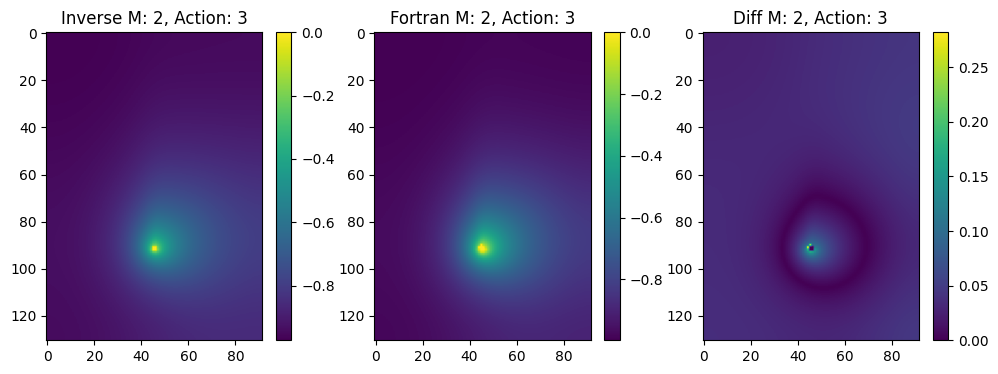

Diff between eta fortran vs inverse
0.06889561021052021


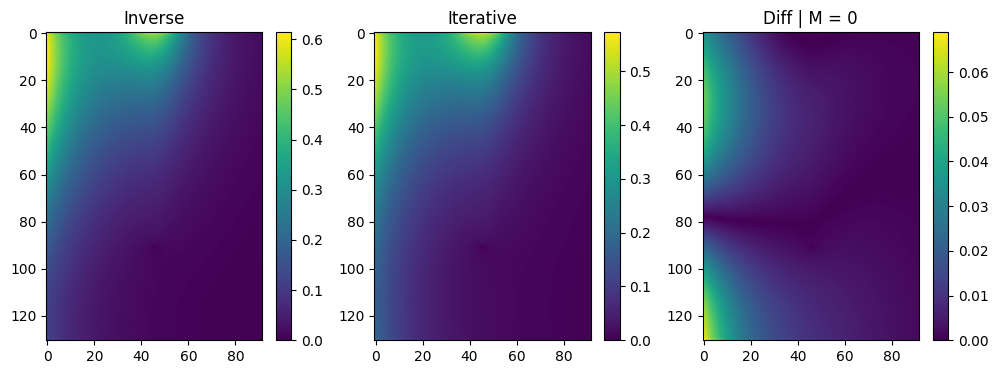

0.06293357391157293


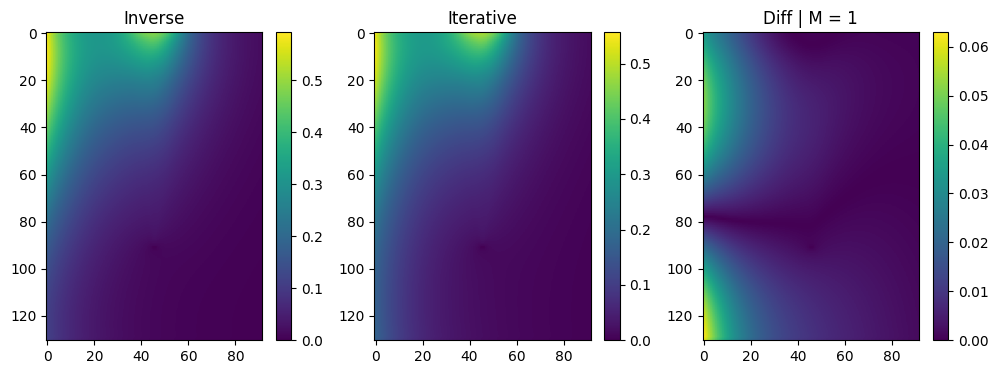

0.06207774995092155


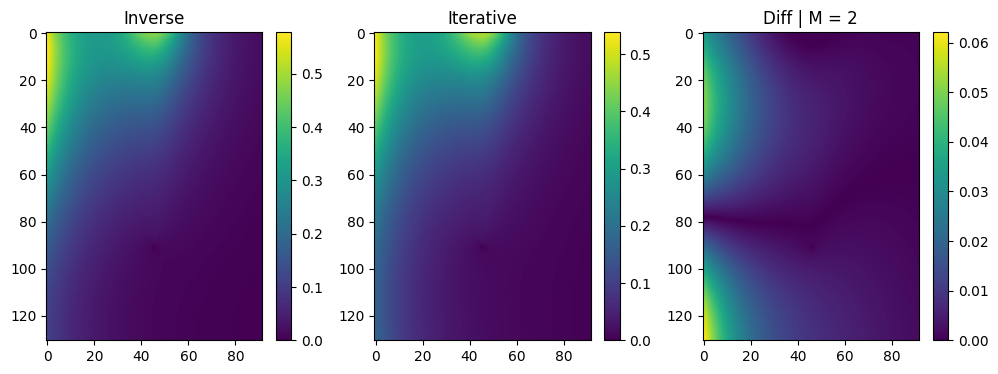

current value: -0.9875663453750965 @ time:2 

current value: -0.9541655809976437 @ time:2 

converged at T=2 with value=-0.9875663453750965
converged at T=2 with value=-0.9541655809976437


In [11]:
#OPTIMIZATION ALGORITHM: NPG
#test print
# Nprint = 100
th_lin = th.copy()

print("Start optimization")

for t in range(Ntot):
    pi = softmax(th, axis=2)
    pi_lin = softmax(th_lin, axis=2)
    
    print("   Direct solver",end=' ')
    time_start = time.time()
    time_full = time.time()
    # Direct solution of linear system
    eta_linSol, T = utils.linear_solve_eta(pi_lin, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range)
    print("eta time: {:.3f}".format(time.time()-time_start),end=' ')
    time_start = time.time()

    V, Q_linSol = utils.linear_solve_Q(T, Lx, Ly, M, A, gamma, find_range, source_as_zero,RR_np)
    print("Q time: {:.3f}".format(time.time()-time_start),end=' ')
    print("Total time: {:.3f}".format(time.time()-time_full))

    print("Iterative solver",end=' ')
    time_start = time.time()
    time_full = time.time()
    # Iterative solutions of linear system
    eta = utils.iterative_solve_eta(pi, PObs_lim, gamma, rho0, eta, tol_eta, Lx, Ly, Lx0, Ly0, find_range)
    print("eta time: {:.3f}".format(time.time()-time_start),end=' ')
    time_start = time.time()

    Q = utils.iterative_solve_Q(pi, PObs_lim, gamma, RR, Q, tol_Q, Lx, Ly, Lx0, Ly0, find_range, cost_move)
    print("Q time: {:.3f}".format(time.time()-time_start),end=' ')

    print("Total time: {:.3f}".format(time.time()-time_full))

    if ((t % Nprint == 1) or (Nprint == 1) and plotPrint):

        print("eta linSol shape", eta_linSol.shape)
        print("Q linSol shape", Q_linSol.shape)
        print("eta shape", eta.shape)
        print("Q shape", Q.shape)

        eta_linSol = eta_linSol.reshape(M,Ly,Lx)
        Q_linSol = Q_linSol.reshape(M,Ly,Lx,M,A)
        eta = eta.reshape(M,Ly,Lx)
        Q = Q.reshape(M,Ly,Lx,M,A)

        # Compare the direct solver and iterative solver
        print("Diff between Q fortran vs inverse")
        for i in range(M):
            for j in range(A):
                print("Memory state: {}, Action: {}, Diff: {}".format(i,j,np.sum(np.abs(Q_linSol[0,:,:,i,j]-Q[0,:,:,i,j]))))
                print("    Inv min: {}, max: {}".format(np.min(Q_linSol[0,:,:,i,j]), np.max(Q_linSol[0,:,:,i,j])))
                print("Fortran min: {}, max: {}".format(np.min(Q[0,:,:,i,j]), np.max(Q[0,:,:,i,j])))
                fig = plt.figure(figsize=(12,4))
                plt.subplot(1,3,1)
                plt.title("Inverse M: {}, Action: {}".format(i,j))
                plt.imshow(Q_linSol[0,:,:,i,j])
                plt.colorbar()
                plt.subplot(1,3,2)
                plt.title("Fortran M: {}, Action: {}".format(i,j))
                plt.imshow(Q[0,:,:,i,j])
                plt.colorbar()
                plt.subplot(1,3,3)
                plt.title("Diff M: {}, Action: {}".format(i,j))
                plt.imshow(np.abs(Q_linSol[0,:,:,i,j]-Q[0,:,:,i,j]))
                plt.colorbar()
                plt.show()

        print("Diff between eta fortran vs inverse")
        for im in range(M):
            fig = plt.figure(figsize=(12,4))
            plt.subplot(1,3,1)
            plt.title("Inverse")
            plt.imshow(eta_linSol[im])
            plt.colorbar()
            plt.subplot(1,3,2)
            plt.title("Iterative")
            plt.imshow(eta[im])
            plt.colorbar()
            plt.subplot(1,3,3)
            plt.title("Diff | M = {}".format(im))
            plt.imshow(np.abs(eta[im]-eta_linSol[im]))
            plt.colorbar()
            print(np.abs(eta[im]-eta_linSol[im]).max())

            plt.show()

        eta_linSol = eta_linSol.flatten()
        Q_linSol = Q_linSol.flatten()
        eta = eta.flatten()
        Q = Q.flatten()

    # Gradient calculation
    grad = utils.find_grad(pi, Q, eta, L, PObs_lim)
    grad -= np.max(grad, axis=2, keepdims=True)

    # Gradient calculation
    grad_lin = utils.find_grad(pi_lin, Q_linSol, eta_linSol, L, PObs_lim)
    grad_lin -= np.max(grad_lin, axis=2, keepdims=True)

    # Reset value for new iteration afterwards
    th += grad * lr_th / np.max(np.abs(grad)) # (t / Ntot + 0.5) #rescaled gradient
    th -= np.max(th, axis=2, keepdims=True)
    th = np.clip(th, -20, 0)

    # Reset value for new iteration afterwards
    th_lin += grad_lin * lr_th / np.max(np.abs(grad_lin)) # (t / Ntot + 0.5) #rescaled gradient
    th_lin -= np.max(th_lin, axis=2, keepdims=True)
    th_lin = np.clip(th_lin, -20, 0)

    # Print and check convergence
    if (t % Nprint == 0):
        pi = softmax(th, axis=2)
        value =  utils.get_value(Q, pi, PObs_lim, L, rho0)
        #print values in a file
        print('current value: {} @ time:{} \n'.format(value, t))
        f.write('current value: {} @ time:{} \n'.format(value, t))
        f.flush()

        # check convergence
        if (abs((value-oldvalue)/value)<tol_conv):
            f.write('converged at T={}'.format(t))
            break
        oldvalue = value

        pi_lin = softmax(th_lin, axis=2)
        value_lin =  utils.get_value(Q_linSol, pi_lin, PObs_lim, L, rho0)
        #print values in a file
        print('current value: {} @ time:{} \n'.format(value_lin, t))

        # check convergence
        oldvalue_lin = value_lin


    #if (t % (Nprint*10) == 0): #save every Nprint*10 in different files
    #    np.savetxt(name_folder + '/file_theta{}.out'.format(t), th.reshape(-1))
    #    np.savetxt(name_folder + '/file_Q{}.out'.format(t), Q.reshape(-1))
    #    np.savetxt(name_folder + '/file_eta{}.out'.format(t), eta.reshape(-1))
    if (t % (Nprint*10) == 0)   :#save every Nprint*10 overwriting previous files
        np.savetxt(name_folder + '/file_theta.out', th.reshape(-1))
        np.savetxt(name_folder + '/file_Q.out', Q.reshape(-1))
        np.savetxt(name_folder + '/file_eta.out', eta.reshape(-1))

# final print of converged policy (or if not converged, until Ntot)
np.savetxt(name_folder + '/file_theta.out', th.reshape(-1))
np.savetxt(name_folder + '/file_Q.out', Q.reshape(-1))
np.savetxt(name_folder + '/file_eta.out', eta.reshape(-1))

if t<Ntot:
    print('converged at T={} with value={}'.format(t,value))
else:
    print('did not converged for {} runs and tolerance {}'.format(Ntot,))
    print('current value: {} @ time:{} \n'.format(value, t))

if t<Ntot:
    print('converged at T={} with value={}'.format(t,value_lin))
else:
    print('did not converged for {} runs and tolerance {}'.format(Ntot,))
    print('current value: {} @ time:{} \n'.format(value_lin, t))

Q shape: (433872,), Q_lin shape (433872,)
Q shape: (3, 131, 92, 3, 4), Q_lin shape (3, 131, 92, 3, 4)


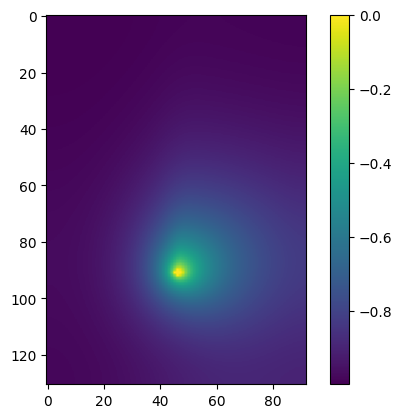

In [12]:
print("Q shape: {}, Q_lin shape {}".format(Q.shape, Q_linSol.shape))
Q = Q.reshape(M,Ly,Lx,M,A)
Q_linSol = Q_linSol.reshape(M,Ly,Lx,M,A)
print("Q shape: {}, Q_lin shape {}".format(Q.shape, Q_linSol.shape))

plt.imshow(Q[0,:,:,0,0])
plt.colorbar()


[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]


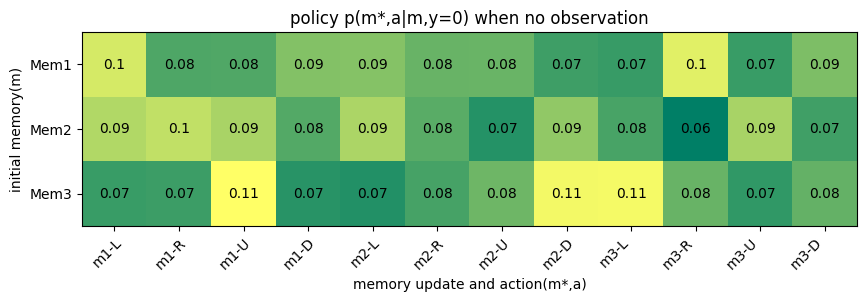

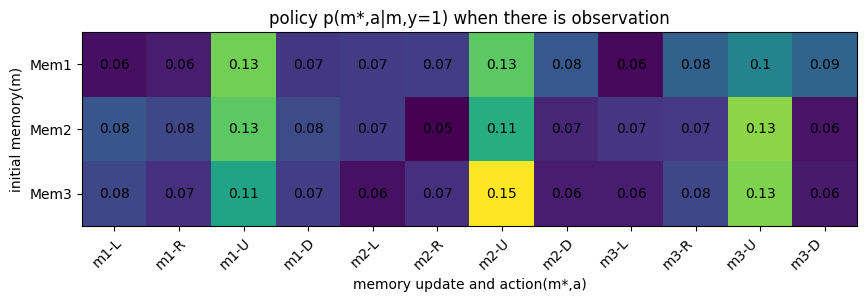

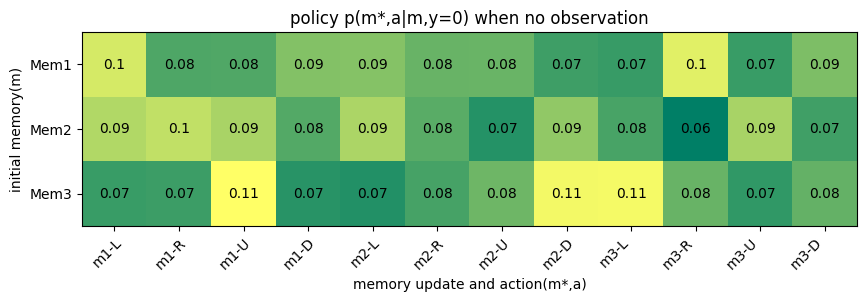

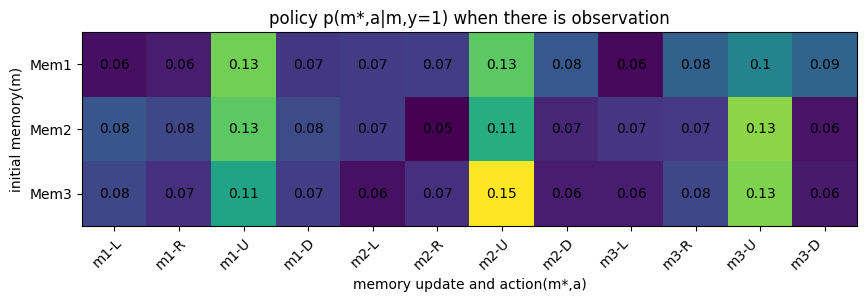

In [18]:
#POLICY ILLUSTRATION
print(pi-pi_lin)
pi_it = pi
for pi in [pi_it, pi_lin]:
    # for y=0
    p0=pi.reshape(O,M,M,A)[0].reshape(M,M*A)
    actions = ["m1-L", "m1-R", "m1-U", "m1-D","m2-L", "m2-R", "m2-U", "m2-D","m3-L", 
               "m3-R", "m3-U", "m3-D","m4-L", "m4-R", "m4-U", "m4-D","m5-L", "m5-R", "m5-U", "m5-D"]
    memory = ["Mem1", "Mem2", "Mem3",
               "Mem4", "Mem5"]

    fig, ax = plt.subplots()
    im = ax.imshow(p0,cmap='summer')
    # Rotate the tick labels and set their alignment.

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(actions[:M*A])), labels=actions[:M*A])
    ax.set_yticks(np.arange(len(memory[:M])), labels=memory[:M])

    p00=np.round(p0,2)
    for i in range(len(memory[:M])):
        for j in range(len(actions[:M*A])):
            if p00[i,j]==0.0:
                text = ax.text(j, i, 0,
                           ha="center", va="center", color="black") 
            else:
                text = ax.text(j, i, p00[i, j],
                           ha="center", va="center", color="black")

    plt.title('policy p(m*,a|m,y=0) when no observation')
    plt.ylabel('initial memory(m)',fontsize=10)
    plt.xlabel('memory update and action(m*,a)',fontsize=10)
    fig.set_size_inches(10, 6)


    #for y=1
    p1=pi.reshape(O,M,M,A)[1].reshape(M,M*A)
    actions = ["m1-L", "m1-R", "m1-U", "m1-D","m2-L", "m2-R", "m2-U", "m2-D","m3-L", 
               "m3-R", "m3-U", "m3-D","m4-L", "m4-R", "m4-U", "m4-D","m5-L", "m5-R", "m5-U", "m5-D"]
    memory = ["Mem1", "Mem2", "Mem3",
               "Mem4", "Mem5"]

    fig, ax = plt.subplots()
    im = ax.imshow(p1)
    # Rotate the tick labels and set their alignment.

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(actions[:M*A])), labels=actions[:M*A])
    ax.set_yticks(np.arange(len(memory[:M])), labels=memory[:M])

    p11=np.round(p1,2)
    for i in range(len(memory[:M])):
        for j in range(len(actions[:M*A])):
            if p11[i,j]==0.0:
                text = ax.text(j, i, '0',
                           ha="center", va="center", color="black") 
            else:
                text = ax.text(j, i, p11[i, j],
                           ha="center", va="center", color="black")

    plt.title('policy p(m*,a|m,y=1) when there is observation')
    plt.ylabel('initial memory(m)',fontsize=10)
    plt.xlabel('memory update and action(m*,a)',fontsize=10)
    fig.set_size_inches(10, 6)
    plt.show()

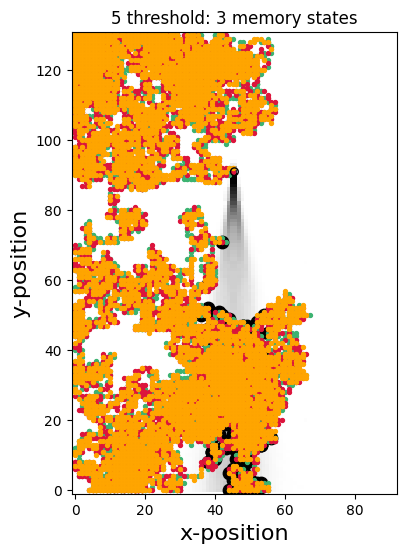

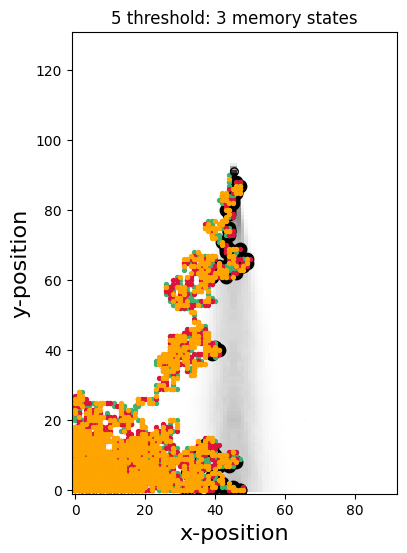

In [14]:
#Visualize after optimization
#Sample Trajectory
th_it = th
for th in [th_it,th_lin]:
    trj, ret, _ = utils.single_traj_obs(softmax(th, axis=2), Lx, Ly, Lx0, Ly0, find_range, gamma, PObs_lim, rho0, A)
    scatter_x = trj[1:,1]
    scatter_y = trj[1:,2]
    group = trj[1:,3]
    cdict = {2: 'orange', 0: 'mediumseagreen', 1: 'crimson', 3:'blue'}
    
    fig, ax = plt.subplots()
    
    ix = np.where(trj[1:,4] > 0)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = 'black', s = 80)
    ix = np.where(group == 0.0)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[0], label = 'Memory 0', s = 8)
    ix = np.where(group == 1.0)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[1], label = 'Memory 1', s = 8)
    ix = np.where(group == 2.0)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[2], label = 'Memory 2', s = 8)
    ix = np.where(group == 3.0)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[3], label = 'Memory 3', s = 8)
    #ax.legend()
    ax.imshow((1-PObs_lim[0,:]-5).reshape(M,Ly,Lx)[0,:],cmap='Greys')
    fig.set_size_inches(10, 6)
    crange=plt.Circle((Lx0,Ly0),find_range,fill=False)
    ax.set_aspect(1)
    
    ax.add_artist(crange)
    plt.title('{} threshold: {} memory states'.format(dth, M))
    plt.xlim((-1,Lx))
    plt.ylim((-1,Ly))
    plt.xlabel('x-position',fontsize=16)
    plt.ylabel('y-position',fontsize=16)
    plt.show()

In [15]:
#TIME DISTRIBUTIONS of search time 
#timedistributions

Nep = 1000    #number of trajectories to reproduce
Nep = 23   #number of trajectories to reproduce
maxT = 10000  #maximum search time, not found before maxT would be counted as "failed search"
maxT = 10000  #maximum search time, not found before maxT would be counted as "failed search"
for th in [th_it,th_lin]:
    av_ret = 0.
    T = []
    for i in range(Nep):
        _, ret, tau = utils.single_traj_obs(softmax(th, axis=2), Lx, Ly, Lx0, Ly0, find_range, maxT, PObs_lim, rho0, A)
        av_ret += ret
        T.append(tau)
    print('Success Rate: {:.3f}%'.format(100*av_ret / Nep))


Success Rate: 0.000%
Success Rate: 13.043%
